In [3]:
import numpy as np
import pandas as pd
import requests
import re

import yfinance as yf
import pandas_datareader as pdr

import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from io import StringIO

import eurostat
import time

# 1) IPOs data from Web
[ipos info](https://stockanalysis.com/ipos/2023/)

In [3]:
def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [4]:
ipos_2023 = get_ipos_by_year(2023)
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      153 non-null    object
 1   Symbol        153 non-null    object
 2   Company Name  153 non-null    object
 3   IPO Price     153 non-null    object
 4   Current       153 non-null    object
 5   Return        153 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [6]:
ipos_2023.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Dec 27, 2023",IROH,Iron Horse Acquisitions Corp.,$10.00,$10.50,4.80%
1,"Dec 19, 2023",LGCB,Linkage Global Inc,$4.00,$2.28,-39.79%
2,"Dec 15, 2023",BAYA,Bayview Acquisition Corp,$10.00,$10.95,9.20%
3,"Dec 15, 2023",ZKH,ZKH Group Limited,$15.50,$3.07,-80.13%
4,"Dec 14, 2023",INHD,Inno Holdings Inc.,$4.00,$1.18,-70.00%


In [7]:
ipos_2024 = get_ipos_by_year(2024)
ipos_2025 = get_ipos_by_year(2025)

In [8]:
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
stacked_ipos_df = pd.concat([ipos_2025, ipos_2024, ipos_2023], ignore_index=True)

In [9]:
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      530 non-null    object
 1   Symbol        530 non-null    object
 2   Company Name  530 non-null    object
 3   IPO Price     530 non-null    object
 4   Current       530 non-null    object
 5   Return        530 non-null    object
dtypes: object(6)
memory usage: 25.0+ KB


In [10]:
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='mixed')

In [11]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
71,2025-04-02,SORA,Top Win International Limited,-,$6.48,-
213,2024-10-11,STFS,Star Fashion Culture Holdings Limited,-,$1.14,-
272,2024-07-23,ZDAI,Primega Group Holdings Limited,-,$0.82,-
300,2024-05-31,NAKA,"Kindly MD, Inc.",-,$13.62,-
326,2024-04-17,SUPX,SuperX AI Technology Limited,-,$9.63,-


In [12]:
# pd.to_numeric() function call, which will convert problematic values to NaN
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

In [13]:
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')
# to percentage
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

In [14]:
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      530 non-null    datetime64[ns]
 1   Symbol        530 non-null    object        
 2   Company Name  530 non-null    object        
 3   IPO Price     525 non-null    float64       
 4   Current       530 non-null    float64       
 5   Return        522 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 25.0+ KB


In [16]:
# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
2,2025-06-13,BSAA,BEST SPAC I Acquisition Corp.,10.0,10.04,NaN
37,2025-05-08,AII,"American Integrity Insurance Group, Inc.",16.0,15.96,NaN
71,2025-04-02,SORA,Top Win International Limited,NaN,6.48,NaN
136,2025-01-22,DGNX,Diginex Limited,4.1,50.25,NaN
213,2024-10-11,STFS,Star Fashion Culture Holdings Limited,NaN,1.14,NaN
272,2024-07-23,ZDAI,Primega Group Holdings Limited,NaN,0.82,NaN
300,2024-05-31,NAKA,"Kindly MD, Inc.",NaN,13.62,NaN
326,2024-04-17,SUPX,SuperX AI Technology Limited,NaN,9.63,NaN


In [17]:
stacked_ipos_df['IPO Price'].mean()

np.float64(10.65)

In [18]:
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']
stacked_ipos_df['Price Increase'].mean()

np.float64(0.9333333333333333)

In [19]:
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,530,525.000000,530.000000,522.000000,525.000000
mean,2024-06-08 13:45:57.735848960,10.650000,11.533849,-0.092880,0.933333
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999500,-45.820000
25%,2023-11-04 06:00:00,4.000000,1.627500,-0.700975,-3.470000
50%,2024-07-29 00:00:00,10.000000,8.355000,-0.079050,-0.760000
75%,2025-01-24 00:00:00,11.000000,11.000000,0.084750,0.830000
max,2025-06-13 00:00:00,92.000000,150.500000,6.740000,110.500000
std,NaN,9.806617,17.969756,0.852207,12.890687


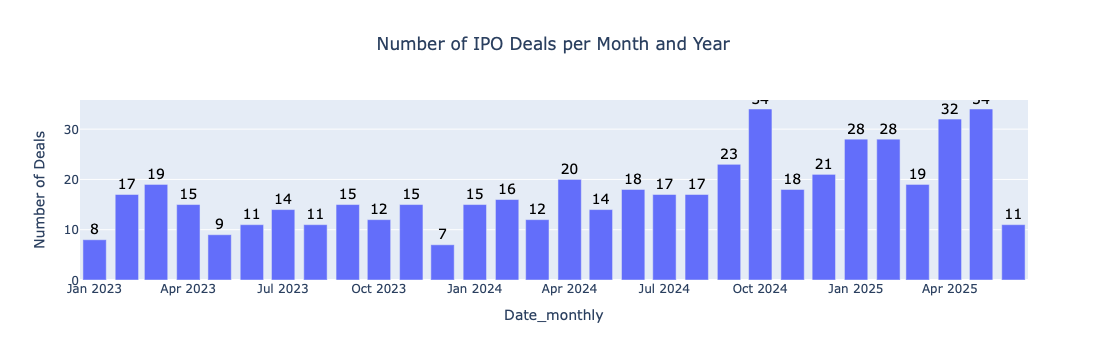

In [20]:
# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [21]:
rddt_filter = stacked_ipos_df.Symbol=='RDDT'
stacked_ipos_df[rddt_filter]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase,Date_monthly
341,2024-03-21,RDDT,"Reddit, Inc.",34.0,118.48,2.4003,84.48,2024-03-01


In [22]:
# You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
ticker_obj = yf.Ticker("RDDT")
reddit = ticker_obj.history(period = "max", interval = "1d")

reddit.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-09 00:00:00-04:00,119.650002,121.980003,116.379997,117.529999,5636100,0.0,0.0
2025-06-10 00:00:00-04:00,116.199997,119.150002,115.260002,117.089996,5631200,0.0,0.0
2025-06-11 00:00:00-04:00,117.400002,120.622002,114.449997,115.029999,5988200,0.0,0.0
2025-06-12 00:00:00-04:00,113.019997,118.120003,110.849998,116.199997,4817200,0.0,0.0
2025-06-13 00:00:00-04:00,112.300003,118.690002,112.470001,118.160004,2957543,0.0,0.0


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

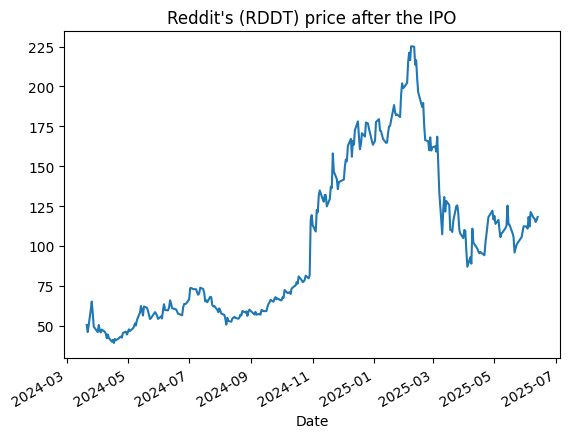

In [23]:
reddit['Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

# 2) OHLCV data transformations

### 2.1 Time series for OHLCV

In [24]:
ticker_obj = yf.Ticker("NVO")
nvo_df = ticker_obj.history(period = "max", interval = "1d")

In [25]:
nvo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11122 entries, 1981-04-30 00:00:00-04:00 to 2025-06-13 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11122 non-null  float64
 1   High          11122 non-null  float64
 2   Low           11122 non-null  float64
 3   Close         11122 non-null  float64
 4   Volume        11122 non-null  int64  
 5   Dividends     11122 non-null  float64
 6   Stock Splits  11122 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 695.1 KB


In [26]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-09 00:00:00-04:00,75.010002,76.849998,74.160004,75.459999,10885800,0.0,0.0
2025-06-10 00:00:00-04:00,77.989998,80.440002,77.440002,79.330002,13076800,0.0,0.0
2025-06-11 00:00:00-04:00,79.080002,79.830002,78.339996,78.730003,9211600,0.0,0.0
2025-06-12 00:00:00-04:00,80.639999,81.160004,79.919998,81.050003,10547400,0.0,0.0
2025-06-13 00:00:00-04:00,81.410004,81.440002,79.620003,80.470001,3775547,0.0,0.0


In [27]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

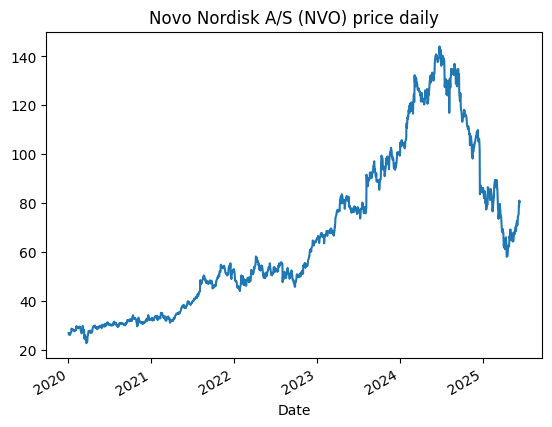

In [28]:
nvo_df_filtered_from_2020['Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')

In [29]:
nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date

In [30]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,,
2025-06-09 00:00:00-04:00,75.010002,76.849998,74.160004,75.459999,10885800,0.0,0.0,NVO,2025,6,0,2025-06-09
2025-06-10 00:00:00-04:00,77.989998,80.440002,77.440002,79.330002,13076800,0.0,0.0,NVO,2025,6,1,2025-06-10
2025-06-11 00:00:00-04:00,79.080002,79.830002,78.339996,78.730003,9211600,0.0,0.0,NVO,2025,6,2,2025-06-11
2025-06-12 00:00:00-04:00,80.639999,81.160004,79.919998,81.050003,10547400,0.0,0.0,NVO,2025,6,3,2025-06-12
2025-06-13 00:00:00-04:00,81.410004,81.440002,79.620003,80.470001,3775547,0.0,0.0,NVO,2025,6,4,2025-06-13


In [31]:
# shift values (on x periods forward (+1) and backward (-1))
nvo_df['close_minus_1'] = nvo_df['Close'].shift(-1)
nvo_df['close_plus_1'] = nvo_df['Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,close_minus_1,close_plus_1
Date,,,,,,,,,,,,,,
2025-06-09 00:00:00-04:00,75.010002,76.849998,74.160004,75.459999,10885800,0.0,0.0,NVO,2025,6,0,2025-06-09,79.330002,74.629997
2025-06-10 00:00:00-04:00,77.989998,80.440002,77.440002,79.330002,13076800,0.0,0.0,NVO,2025,6,1,2025-06-10,78.730003,75.459999
2025-06-11 00:00:00-04:00,79.080002,79.830002,78.339996,78.730003,9211600,0.0,0.0,NVO,2025,6,2,2025-06-11,81.050003,79.330002
2025-06-12 00:00:00-04:00,80.639999,81.160004,79.919998,81.050003,10547400,0.0,0.0,NVO,2025,6,3,2025-06-12,80.470001,78.730003
2025-06-13 00:00:00-04:00,81.410004,81.440002,79.620003,80.470001,3775547,0.0,0.0,NVO,2025,6,4,2025-06-13,NaN,81.050003


In [32]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Close'] / nvo_df['Close'].shift(1)   # nvo_df['close_plus_1']
nvo_df['growth_30d'] = nvo_df['Close'] / nvo_df['Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Close'].shift(-1) / nvo_df['Close']   # nvo_df['close_minus_1']
nvo_df['growth_future_30d'] = nvo_df['Close'].shift(-30) / nvo_df['Close']   # nvo_df['close_minus_1']

# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)
nvo_df['is_positive_growth_30d_future'] = np.where(nvo_df['growth_future_30d'] > 1, 1, 0)

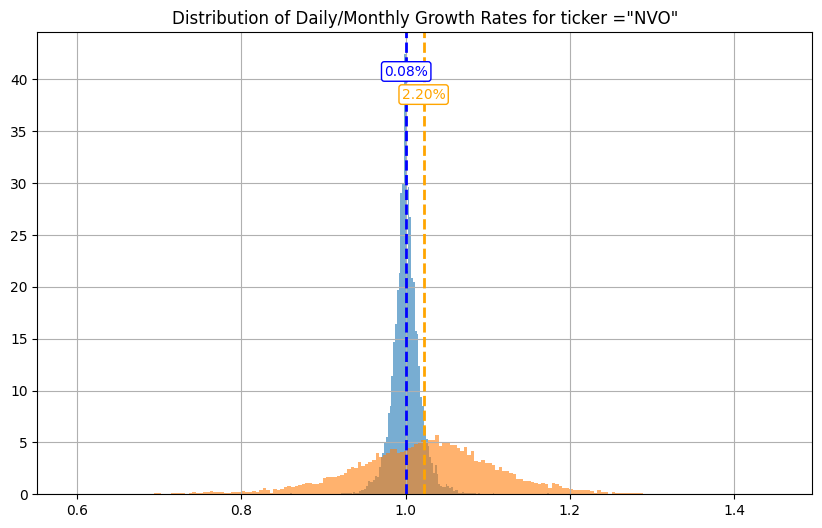

In [33]:
# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.figure(figsize=(10, 6))
plt.title('Distribution of Daily/Monthly Growth Rates for ticker ="NVO"')

nvo_df.growth_1d.hist(bins=200, alpha=0.6, density=True)
nvo_df.growth_30d.hist(bins=200, alpha=0.6, density=True)

# Add vertical lines for averages
mean_1d = nvo_df.growth_1d.mean()
mean_30d = nvo_df.growth_30d.mean()

plt.axvline(mean_1d, color='blue', linestyle='--', linewidth=2, label=f'1d avg = {mean_1d:.3f}')
plt.axvline(mean_30d, color='orange', linestyle='--', linewidth=2, label=f'30d avg = {mean_30d:.3f}')


# Add mean text labels (as percent change)
ymax = plt.ylim()[1]
plt.text(mean_1d, ymax * 0.90,
         f'{(mean_1d - 1) * 100:.2f}%',
         color='blue', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.2'))

plt.text(mean_30d, ymax * 0.85,
         f'{(mean_30d - 1) * 100:.2f}%',
         color='orange', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.2'))


plt.show()

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

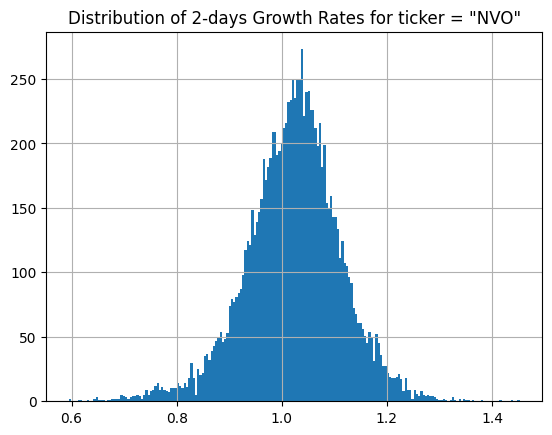

In [34]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [35]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Close']
nvo_df[COLUMNS].tail()

,Close,growth_1d,growth_30d,growth_future_1d,growth_future_30d,is_positive_growth_1d_future,is_positive_growth_30d_future
Date,,,,,,,
2025-06-09 00:00:00-04:00,75.459999,1.011122,1.215528,1.051285,NaN,1,0
2025-06-10 00:00:00-04:00,79.330002,1.051285,1.266848,0.992437,NaN,0,0
2025-06-11 00:00:00-04:00,78.730003,0.992437,1.208257,1.029468,NaN,1,0
2025-06-12 00:00:00-04:00,81.050003,1.029468,1.219714,0.992844,NaN,0,0
2025-06-13 00:00:00-04:00,80.470001,0.992844,1.226677,NaN,NaN,0,0


In [36]:
# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)

is_positive_growth_1d_future
0    0.512857
1    0.487143
Name: count, dtype: float64

In [37]:
nvo_df.is_positive_growth_30d_future.value_counts() / len(nvo_df)

is_positive_growth_30d_future
1    0.619942
0    0.380058
Name: count, dtype: float64

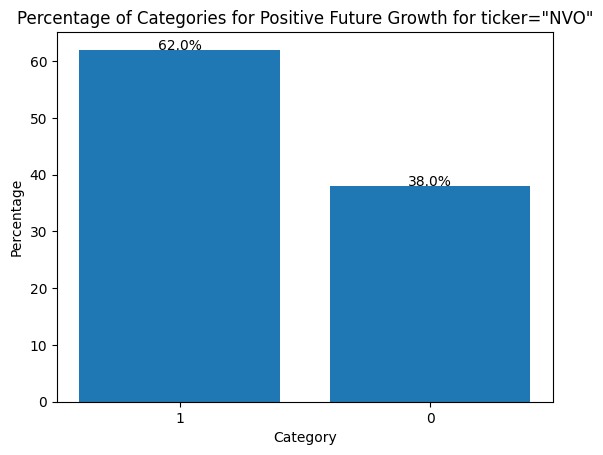

In [38]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_30d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

### 2.2) Candlestick chart for OHLCV
open high low close volume

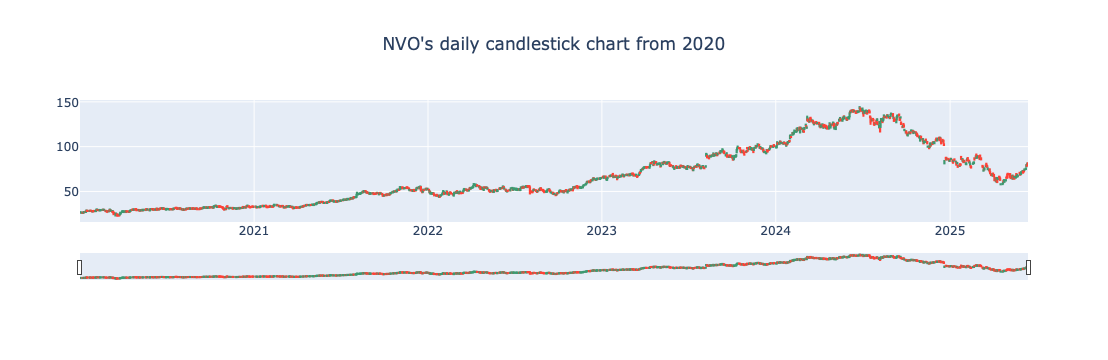

In [39]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

bull - growing days (green) - close > open; bear - declining days (red) - close < open
* SMA10 (simple moving average 10 days)
* SMA20 (simple moving average 20 days)
* [Bye when SMA10 is lower and intersects SMA20, sell when they interescts again in the upper side](https://www.tradingview.com/chart/EURUSD/TXANiPQP-Simple-Trading-Strategy-10-20-SMA/)

# 3) Macro Indicators

### 3.0) Previous indicators from module 1

In [40]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2025; month= 6; day=13
Period for indexes: 1955-06-13 to 2025-06-13 


In [41]:
ticker_obj = yf.Ticker("^GDAXI")
dax_daily = ticker_obj.history(period = "max", interval = "1d")

In [42]:
for i in [1,3,7,30,90,365]:
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Close'] / dax_daily['Close'].shift(i)

In [43]:
dax_daily.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
2025-06-09 00:00:00+02:00,24252.259766,24289.509766,24097.089844,24174.320312,35991400,0.0,0.0,0.994645,0.995792,1.010073,1.086855,1.117240,1.447430
2025-06-10 00:00:00+02:00,24156.529297,24168.589844,23964.769531,23987.560547,59033500,0.0,0.0,0.992274,0.986185,0.999587,1.077044,1.104034,1.431953
2025-06-11 00:00:00+02:00,23996.660156,24151.390625,23948.570312,23948.900391,62192700,0.0,0.0,0.998388,0.985371,1.000762,1.067916,1.102008,1.428134
2025-06-12 00:00:00+02:00,23768.050781,23885.060547,23618.849609,23771.449219,63677900,0.0,0.0,0.992590,0.983335,0.986710,1.056651,1.109351,1.437350
2025-06-13 00:00:00+02:00,23448.189453,23557.710938,23360.160156,23516.230469,0,0.0,0.0,0.989264,0.980351,0.968684,1.018607,1.093488,1.415166


In [44]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]

In [2]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Close'] / df['Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [46]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
ticker_obj = yf.Ticker("^GSPC")

# snp500_daily = yf.download(tickers = "^GSPC",
#                      period = "max",
#                      interval = "1d")

snp500_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [47]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,1.003822,1.006557,1.012544,1.085508,1.008456,1.264281
2025-06-13 00:00:00-04:00,0.996702,0.997766,1.009129,1.075155,0.997920,1.259644


In [48]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch

ticker_obj = yf.Ticker("^DJI")

# dji_daily = yf.download(tickers = "^DJI",
#                      period = "max",
#                      interval = "1d")


dji_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [49]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)

,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,1.002376,1.004814,1.010536,1.056511,0.967262,1.141041
2025-06-13 00:00:00-04:00,0.991067,0.993396,1.003678,1.044925,0.955735,1.129241


In [50]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI

# epi_etf_daily = yf.download(tickers = "EPI",
#                      period = "max",
#                      interval = "1d")

ticker_obj = yf.Ticker("EPI")
epi_etf_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

epi_etf_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-06-12 00:00:00-04:00,46.820000,46.930,46.770000,46.900002,592100,0.0,0.0,0.0
2025-06-13 00:00:00-04:00,46.130001,46.395,46.130001,46.389999,514354,0.0,0.0,0.0


In [51]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,0.991334,0.997448,1.018458,1.034863,1.083892,1.147758
2025-06-13 00:00:00-04:00,0.989126,0.983047,1.008259,1.024062,1.059374,1.127297


In [52]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1

gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [53]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-04-01,0.027815,0.002368
2025-05-01,0.027671,0.001299


In [54]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

,FEDFUNDS
DATE,
2025-04-01,4.33
2025-05-01,4.33


In [55]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

,DGS1
DATE,
2025-06-10,4.12
2025-06-11,4.08


In [56]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2025-06-10,4.08
2025-06-11,4.02


In [57]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)

,DGS10
DATE,
2025-06-10,4.47
2025-06-11,4.41


### 3.1) VIX - Volatility Index

In [3]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/

ticker_obj = yf.Ticker("^VIX")

# vix = yf.download(tickers = "^VIX",
#                      period = "max",
#                      interval = "1d")

vix = ticker_obj.history(
                     period = "max",
                     interval = "1d")

vix.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-13 00:00:00-05:00,21.760000,22.000000,18.879999,20.82,0,0.0,0.0
2025-06-16 00:00:00-05:00,19.780001,20.219999,19.650000,19.73,0,0.0,0.0


In [4]:
vix_to_merge = vix['Close']
vix_to_merge.tail()

Date
2025-06-10 00:00:00-05:00    16.950001
2025-06-11 00:00:00-05:00    17.260000
2025-06-12 00:00:00-05:00    18.020000
2025-06-13 00:00:00-05:00    20.820000
2025-06-16 00:00:00-05:00    19.730000
Name: Close, dtype: float64

<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

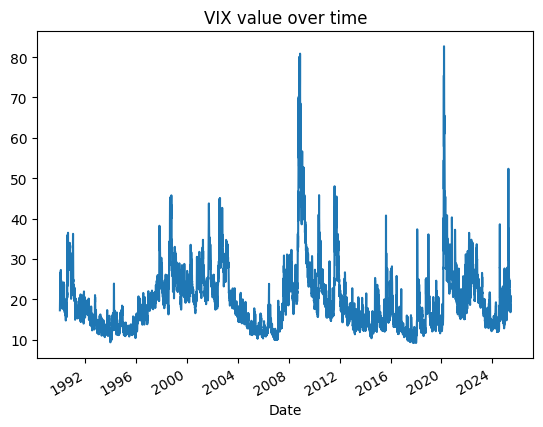

In [5]:
vix['Close'].plot.line(title = "VIX value over time")

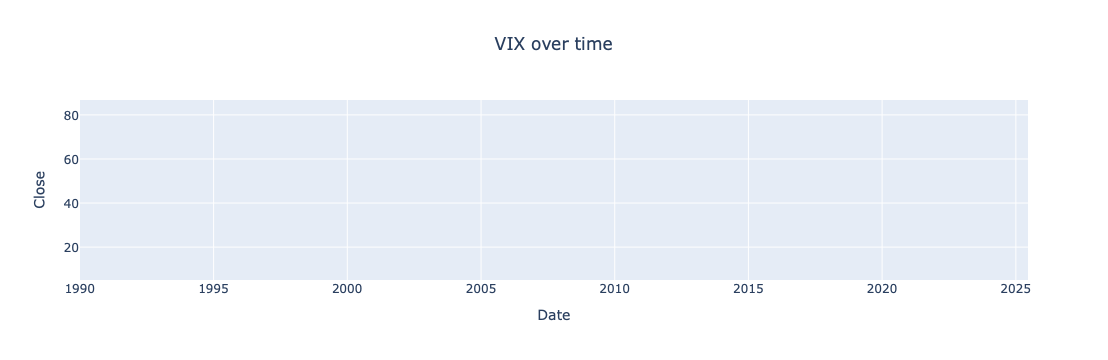

In [6]:
# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

VIX spikes indicates high market uncertainity

### 3.2) Gold - other assets

In [7]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF

ticker_obj = yf.Ticker("GC=F")

# gold = yf.download(tickers = "GC=F",
#                      period = "max",
#                      interval = "1d")

gold = ticker_obj.history(
                     period = "max",
                     interval = "1d")

gold.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-13 00:00:00-04:00,3407.300049,3444.000000,3407.300049,3431.199951,1818,0.0,0.0
2025-06-16 00:00:00-04:00,3473.000000,3476.300049,3428.899902,3435.699951,98717,0.0,0.0


In [10]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-13 00:00:00-04:00,1.014878,1.033214,1.017104,1.068910,1.202537,1.663693
2025-06-16 00:00:00-04:00,1.001311,1.034444,1.025368,1.063059,1.196441,1.664261


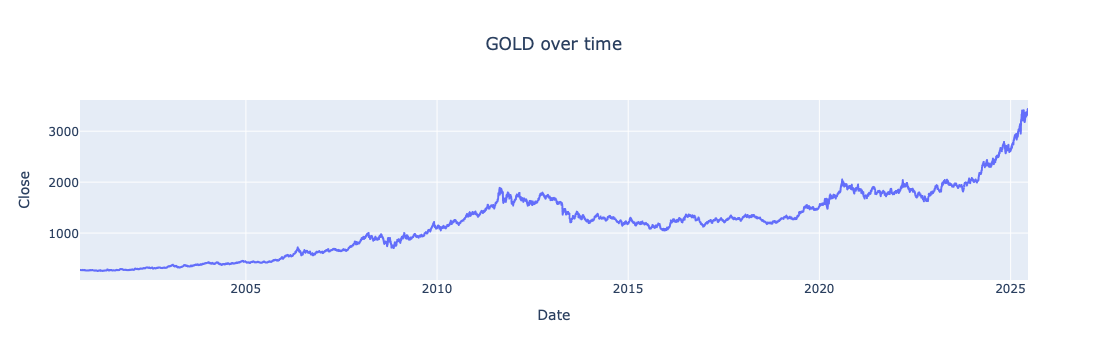

In [11]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

Gold continues upward trajectory, make stronge safe status

### 3.3) WTI Crude and Brent Oil

In [12]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/

ticker_obj = yf.Ticker("CL=F")

# crude_oil = yf.download(tickers = "CL=F",
#                      period = "max",
#                      interval = "1d")

crude_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

crude_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-13 00:00:00-04:00,68.900002,77.620003,68.489998,72.980003,379394,0.0,0.0
2025-06-16 00:00:00-04:00,76.540001,77.489998,71.260002,71.669998,128292,0.0,0.0


In [13]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2025-06-13 00:00:00-04:00,1.072604,1.123115,1.161177,1.231938,1.003852,1.018562
2025-06-16 00:00:00-04:00,0.982050,1.051651,1.130977,1.229542,1.009010,1.018329


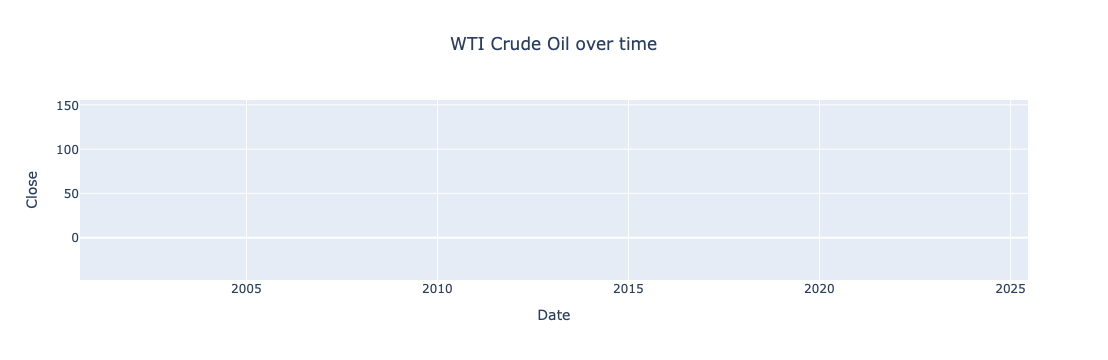

In [14]:
# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [15]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/

ticker_obj = yf.Ticker("BZ=F")

# brent_oil = yf.download(tickers = "BZ=F",
#                      period = "max",
#                      interval = "1d")

brent_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-13 00:00:00-04:00,70.269997,78.529999,69.919998,74.230003,60336,0.0,0.0
2025-06-16 00:00:00-04:00,76.809998,78.480003,72.620003,73.139999,42570,0.0,0.0


In [16]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2025-06-13 00:00:00-04:00,1.070213,1.110064,1.144465,1.194753,0.974147,0.963525
2025-06-16 00:00:00-04:00,0.985316,1.048302,1.119376,1.193343,0.980298,0.963763


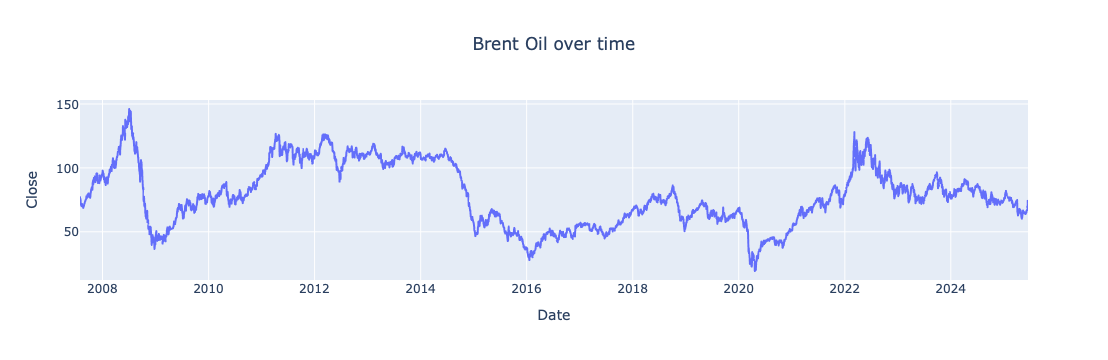

In [17]:
# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

Brent Oil continue to decline, reflecting possible oversupply or reduced demand

### 3.4) Bitcoin prices: BTC_USD

In [18]:
# https://finance.yahoo.com/quote/BTC-USD/

ticker_obj = yf.Ticker("BTC-USD")

# btc_usd =  yf.download(tickers = "BTC-USD",
#                      period = "max",
#                      interval = "1d")


btc_usd =  ticker_obj.history(
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-15 00:00:00+00:00,105464.843750,106157.101562,104519.882812,105552.023438,36744307742,0.0,0.0
2025-06-16 00:00:00+00:00,105576.960938,107227.062500,105121.273438,106655.250000,43169959936,0.0,0.0


In [19]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2025-06-15 00:00:00+00:00,1.000755,0.996441,0.997716,1.019932,1.255441,1.594658
2025-06-16 00:00:00+00:00,1.010452,1.005319,0.967008,1.033570,1.289376,1.600492


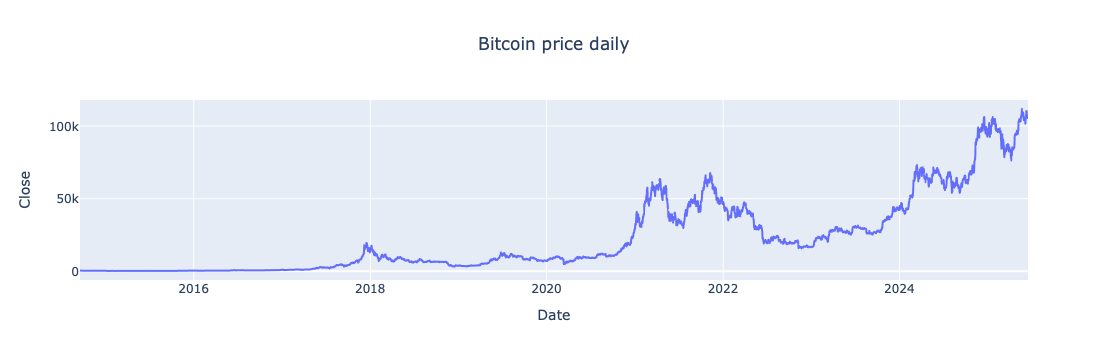

In [20]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

Bitcoin reaches all time highs, underscoring its increasing role as an alternative asset

### 3.5 Eurostat: "The home of high-quality statistics and data on Europe"
https://ec.europa.eu/eurostat/web/main/data/database

In [2]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2025-05-01', 'endPeriod':'2025-06-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [3]:
eurostat_euro_yield_df.head()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,


In [4]:
eurostat_euro_yield_df['bonds'].value_counts()

bonds
CGB_EA        1074
CGB_EA_AAA    1074
Name: count, dtype: int64

In [5]:
eurostat_euro_yield_df['maturity'].value_counts()

maturity
M10       6
Y26_M8    6
Y28_M4    6
Y28_M3    6
Y28_M2    6
         ..
Y18_M9    6
Y18_M8    6
Y18_M7    6
Y18_M6    6
Y9_M9     6
Name: count, Length: 358, dtype: int64

In [6]:
eurostat_euro_yield_df['yld_curv'].value_counts()

yld_curv
INS_FWD    716
PAR        716
SPOT_RT    716
Name: count, dtype: int64

In [7]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [8]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-05_value']].head(10)

,maturity,2025-05-05_value
1433,M10,1.79463
1435,M11,1.78389
1437,M3,1.91227
1439,M4,1.89037
1441,M5,1.87031
1443,M6,1.85200
1445,M7,1.83535
1447,M8,1.82029
1449,M9,1.80674
1451,Y1,1.77444


In [9]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-29_value']].head(10)

,maturity,2025-05-29_value
1433,M10,1.78884
1435,M11,1.78214
1437,M3,1.86951
1439,M4,1.85393
1441,M5,1.83981
1443,M6,1.82708
1445,M7,1.81569
1447,M8,1.80555
1449,M9,1.79662
1451,Y1,1.77647


In [12]:
def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [13]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

/var/folders/rj/25gyk3bn7_g60b0fxzrg3jn40000gq/T/ipykernel_23717/4252248257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eurostat_euro_yield_df.loc[:,'maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))


In [14]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2025-05-29_value']].head(20)

,maturity,maturity_in_months,2025-05-29_value
1437,M3,3,1.86951
1439,M4,4,1.85393
1441,M5,5,1.83981
1443,M6,6,1.82708
1445,M7,7,1.81569
1447,M8,8,1.80555
1449,M9,9,1.79662
1433,M10,10,1.78884
1435,M11,11,1.78214
1451,Y1,12,1.77647


In [15]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

/var/folders/rj/25gyk3bn7_g60b0fxzrg3jn40000gq/T/ipykernel_23717/2163179308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0


<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

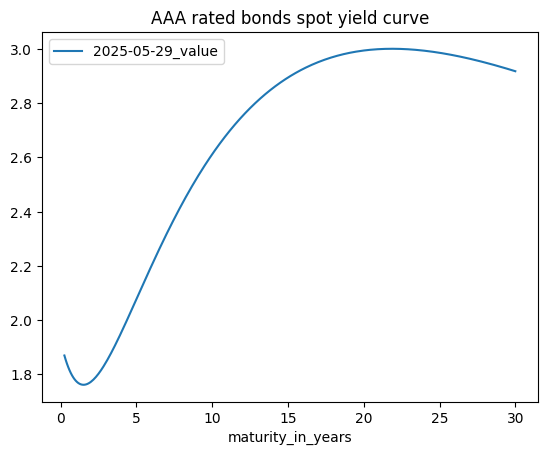

In [16]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2025-05-29_value']] \
  .plot.line(x='maturity_in_years',
            y='2025-05-29_value',
            title='AAA rated bonds spot yield curve')

[Euro Area Yield curves](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html) - relationship betweem market remuneration (win) rates and the remaining time to maturity of debt securities. (term structure of interest rates)

# 4) Fundamental indicators
* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/
* https://www.gurufocus.com/stock/NVO/summary?search
* https://www.investopedia.com/terms/f/fundamentalanalysis.asp

In [3]:
# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]
one_company = yf.Ticker(ticker)

Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day), unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)

In [4]:
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings

,EPS Estimate,Reported EPS,Surprise(%),Ticker
Earnings Date,,,,
2026-05-13 09:30:00-04:00,NaN,NaN,NaN,WMT
2026-02-19 09:30:00-05:00,NaN,NaN,NaN,WMT
2025-11-20 09:30:00-05:00,NaN,NaN,NaN,WMT
2025-08-21 09:30:00-04:00,NaN,NaN,NaN,WMT
2025-05-15 07:01:00-04:00,0.58,0.61,5.93,WMT
2025-02-20 06:59:00-05:00,0.64,0.66,2.57,WMT
2024-11-19 07:00:00-05:00,0.53,0.58,8.82,WMT
2024-08-15 07:02:00-04:00,0.65,0.67,3.78,WMT
2024-05-16 07:01:00-04:00,0.52,0.60,14.60,WMT


In [5]:
one_company.calendar

{'Dividend Date': datetime.date(2026, 1, 5),
 'Ex-Dividend Date': datetime.date(2025, 8, 15),
 'Earnings Date': [datetime.date(2025, 8, 21)],
 'Earnings High': 0.9,
 'Earnings Low': 0.67,
 'Earnings Average': 0.73007,
 'Revenue High': 176653000000,
 'Revenue Low': 172272000000,
 'Revenue Average': 174085276030}

In [6]:
one_company.financials

,2025-01-31,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,-612140000.0,NaN
Tax Rate For Calcs,0.234,0.255,0.336,0.254,NaN
Normalized EBITDA,42010000000.0,36384000000.0,30089000000.0,33758000000.0,NaN
Total Unusual Items,NaN,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,NaN,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,19436000000.0,15511000000.0,11680000000.0,13673000000.0,NaN
Reconciled Depreciation,12973000000.0,11853000000.0,10945000000.0,10658000000.0,NaN
Reconciled Cost Of Revenue,511753000000.0,490142000000.0,463721000000.0,429000000000.0,NaN
EBITDA,42010000000.0,36384000000.0,30089000000.0,31348000000.0,NaN
EBIT,29037000000.0,24531000000.0,19144000000.0,20690000000.0,NaN


In [7]:
EPS = one_company.financials.loc['Basic EPS']
EPS

2025-01-31        2.42
2024-01-31        1.92
2023-01-31        1.43
2022-01-31    1.633333
2021-01-31         NaN
Name: Basic EPS, dtype: object

In [8]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']

In [9]:
EBITDA_margin

2025-01-31     0.06169
2024-01-31    0.056137
2023-01-31    0.049222
2022-01-31    0.054732
2021-01-31         NaN
dtype: object

In [10]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']

In [11]:
# Compare with Public information - you can fully replicate the numbers (yearly and/or quarterly):
# https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement
NET_INCOME_margin

2025-01-31    0.028541
2024-01-31    0.023932
2023-01-31    0.019107
2022-01-31    0.023872
2021-01-31         NaN
dtype: object

In [12]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 * EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

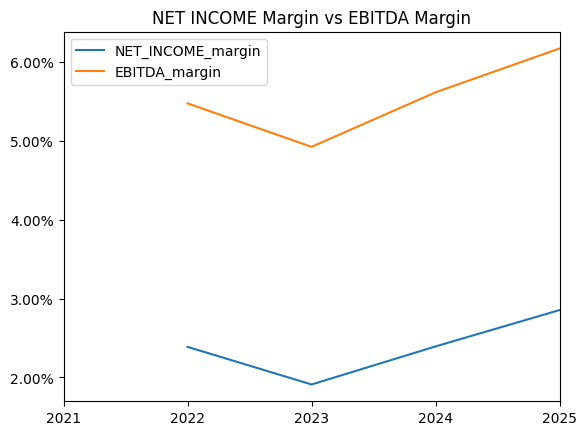

In [14]:
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('NET INCOME Margin vs EBITDA Margin')
plt.show()

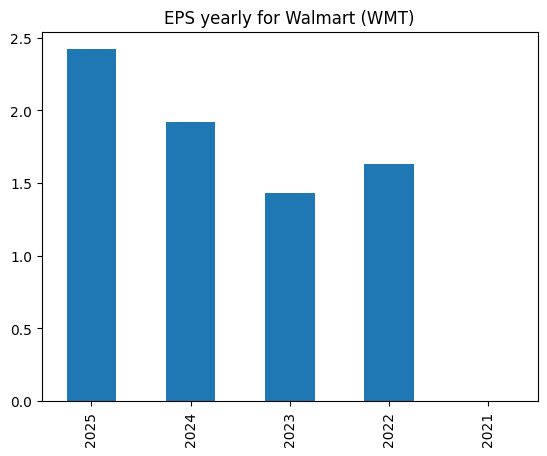

In [16]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
plt.show()

### 5) Daily OHCLV data for a set of stocks

In [4]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [5]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS

* key: Date, Ticker
* predict: growth_future_30d; is_positive_growth_30d_future

In [8]:
stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
    print(i,ticker)
    
    # Work with stock prices
    ticker_obj = yf.Ticker(ticker)
    
    # historyPrices = yf.download(tickers = ticker,
    #                    period = "max",
    #                    interval = "1d")
    historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")
    
    # generate features for historical prices, and what we want to predict
    historyPrices['Ticker'] = ticker
    historyPrices['Year']= historyPrices.index.year
    historyPrices['Month'] = historyPrices.index.month
    historyPrices['Weekday'] = historyPrices.index.weekday
    historyPrices['Date'] = historyPrices.index.date
    
    # historical returns
    for i in [1,3,7,30,90,365]:
        historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
    historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']
    
    # Technical indicators
    # SimpleMovingAverage 10 days and 20 days
    historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
    historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
    historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
    historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']
    
    # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
    historyPrices['volatility'] = historyPrices['growth_1d'].rolling(30).std() * np.sqrt(252)
    
    # what we want to predict
    historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)
    
    # sleep 1 sec between downloads - not to overload the API server
    time.sleep(1)
    
    
    if stocks_df.empty:
        stocks_df = historyPrices
    else:
        stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT
1 AAPL
2 GOOG
3 NVDA
4 AMZN
5 META
6 BRK-B
7 LLY
8 AVGO
9 V
10 JPM
11 NVO
12 MC.PA
13 ASML
14 RMS.PA
15 OR.PA
16 SAP
17 ACN
18 TTE
19 SIE.DE
20 IDEXY
21 CDI.PA
22 RELIANCE.NS
23 TCS.NS
24 HDB
25 BHARTIARTL.NS
26 IBN
27 SBIN.NS
28 LICI.NS
29 INFY
30 ITC.NS
31 HINDUNILVR.NS
32 LT.NS


In [9]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'

In [10]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [11]:
# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

ticker_type
US       83797
EU       80171
INDIA    66406
Name: count, dtype: int64

In [12]:
# unique tickers
stocks_df.Ticker.nunique()

33

In [13]:
stocks_df.Ticker.value_counts()

Ticker
LLY              13374
JPM              11408
AAPL             11220
NVO              11125
MSFT              9894
CDI.PA            8614
TTE               8472
ASML              7617
SAP               7488
HINDUNILVR.NS     7400
SBIN.NS           7398
RELIANCE.NS       7397
ITC.NS            7397
SIE.DE            7330
BRK-B             7325
AMZN              7068
NVDA              6643
INFY              6610
MC.PA             6544
RMS.PA            6544
OR.PA             6544
IBN               6345
ACN               6015
HDB               6014
LT.NS             5705
BHARTIARTL.NS     5702
TCS.NS            5673
GOOG              5242
V                 4341
AVGO              3992
IDEXY             3878
META              3290
LICI.NS            765
Name: count, dtype: int64

In [14]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

,,min,max
Ticker,ticker_type,,
AAPL,US,1980-12-12,2025-06-18
ACN,EU,2001-07-19,2025-06-18
AMZN,US,1997-05-15,2025-06-18
ASML,EU,1995-03-15,2025-06-18
AVGO,US,2009-08-06,2025-06-18
BHARTIARTL.NS,INDIA,2002-07-01,2025-06-19
BRK-B,US,1996-05-09,2025-06-18
CDI.PA,EU,1992-01-27,2025-06-19
GOOG,US,2004-08-19,2025-06-18


In [15]:
#  average growth 365days
stocks_df[stocks_df.Year >= 2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.239693
      INDIA          1.101557
      US             1.484070
2021  EU             1.579891
      INDIA          1.545798
      US             1.797571
2022  EU             1.191168
      INDIA          1.379889
      US             1.182379
2023  EU             1.247592
      INDIA          1.202881
      US             1.203253
2024  EU             1.407607
      INDIA          1.356363
      US             2.159361
2025  EU             1.166514
      INDIA          1.214793
      US             1.668970
Name: growth_365d, dtype: float64

In [16]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [17]:
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191907 entries, 3490 to 230373
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           191907 non-null  float64       
 1   High                           191907 non-null  float64       
 2   Low                            191907 non-null  float64       
 3   Close                          191907 non-null  float64       
 4   Volume                         191907 non-null  int64         
 5   Dividends                      191907 non-null  float64       
 6   Stock Splits                   191907 non-null  float64       
 7   Ticker                         191907 non-null  object        
 8   Year                           191907 non-null  int32         
 9   Month                          191907 non-null  int32         
 10  Weekday                        191907 non-null  int32         
 11  Da

In [18]:
stocks_df[stocks_df.Date=='2025-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_90d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future,ticker_type
203208,795.000000,806.000000,792.099976,797.750000,726877,0.0,0.0,LICI.NS,2025,4,...,0.904530,1.249596,1.071827,786.810004,767.930005,1,0.017424,337.725353,1,INDIA
209817,18.190001,18.209999,17.950001,18.200001,13574900,0.0,0.0,INFY,2025,4,...,0.842593,1.105543,1.014286,18.432000,18.730500,0,0.014286,17.068021,1,INDIA
217215,402.386004,406.902788,398.262008,399.292999,15206240,0.0,0.0,ITC.NS,2025,4,...,0.903574,0.964762,1.070577,400.068704,398.897778,1,0.021640,69.909597,1,INDIA
224615,2259.000000,2284.649902,2220.000000,2233.850098,2495962,0.0,0.0,HINDUNILVR.NS,2025,4,...,0.937490,0.915983,1.066634,2237.069995,2215.125000,1,0.028941,691.003186,1,INDIA
230320,3447.844234,3469.244743,3398.306242,3405.043457,1935147,0.0,0.0,LT.NS,2025,4,...,0.986594,1.119635,1.047544,3377.198193,3277.881909,1,0.020833,1726.860104,1,INDIA


# 6) Technical Indicators with TA-lib
[books](https://www.investopedia.com/articles/personal-finance/090916/top-5-books-learn-technical-analysis.asp)

[generating 100+ tech. indicators](https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb)

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md

* Overlap Studies (17)
* Momentum Indicators (30+)
* Volume Indicators (3)
* Cycle Indicators (5)
* Price Transform (4)
* Volatility Indicators (3)
* Pattern Recognition (60)

In [19]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
# import talib

In [1]:
# # [2025 way - seems to be working] https://medium.com/@Tobi_Lux/collaboration-of-colab-yfinance-and-ta-lib-recent-issues-6cd8eebb56b0
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# !pip install conda-package-handling
# !wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
# !cph x ta-lib-0.5.1-py311h9ecbd09_0.conda

# 🛠 Option 1: Remove the existing directory first (clean, but destructive)
# !rm -rf /usr/local/lib/python3.11/dist-packages/talib

# !mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/

In [1]:
import talib

ImportError: dlopen(/Users/iuliia/projects/market_zoomcamp/venv/lib/python3.11/site-packages/talib/_ta_lib.cpython-311-darwin.so, 0x0002): symbol not found in flat namespace '_TA_ACCBANDS'

### 6.1) Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [4]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index 
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

### 6.2 Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [7]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

### 6.3) Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [8]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

### 6.4) Calculate Tech Indicators and Merge to the original dataframe

In [ ]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [ ]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [ ]:
stocks_df.info()

In [ ]:
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

In [ ]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

In [ ]:
merged_df_with_tech_ind.info()

# 7) Merge All Together

In [ ]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

dax_daily_to_merge.index = dax_daily_to_merge.index.tz_localize(None)
snp500_to_merge.index = snp500_to_merge.index.tz_localize(None)
dji_daily_to_merge.index = dji_daily_to_merge.index.tz_localize(None)
epi_etf_daily_to_merge.index = epi_etf_daily_to_merge.index.tz_localize(None)
vix_to_merge.index = vix_to_merge.index.tz_localize(None)
gold_to_merge.index = gold_to_merge.index.tz_localize(None)
crude_oil_to_merge.index = crude_oil_to_merge.index.tz_localize(None)
brent_oil_to_merge.index = brent_oil_to_merge.index.tz_localize(None)
btc_usd_to_merge.index = btc_usd_to_merge.index.tz_localize(None)

In [ ]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].ffill()
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].ffill()
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].ffill()

In [ ]:
m16.info()

In [ ]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

In [ ]:
m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')